# Impot libraries #

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sqlite3

# Define files to read #

## Parcelles ##

In [2]:
file_NPCS_PARV = "../data/shapefiles/NPCS_CAD_TPR_PARV_S.shp"
file_MOVD_PARV= "../data/shapefiles/MOVD_CAD_TPR_PARV_S.shp"
#file_NPCS_DDP = "../data/shapefiles/NPCS_CAD_TPR_DDP_S.shp"
#file_MOVD_DDP = "../data/shapefiles/MOVD_CAD_TPR_DDP_S.shp"

## Other data ##

In [3]:
file_communes_vd = '../data/communes_vd.csv'

# DB connexion #

In [4]:
db_file = '../data/APMK.sqlite'
con = sqlite3.connect(db_file)

# Load parcelles data #

In [5]:
parcelles_NPCS_PARV = gpd.read_file(file_NPCS_PARV)
parcelles_MOVD_PARV = gpd.read_file(file_MOVD_PARV)
#parcelles_NPCS_DDP = gpd.read_file(file_NPCS_DDP)
#parcelles_MOVD_DDP = gpd.read_file(file_MOVD_DDP)

## Merge parcelles dataframe ##

In [6]:
parcelles_shape = pd.concat([parcelles_NPCS_PARV, parcelles_MOVD_PARV])
#parcelles_shape2 = pd.concat([parcelles_NPCS_DDP, parcelles_MOVD_DDP])
#parcelles_shape2.insert(1, 'IDEX2000', "")
#parcelles_shape = pd.concat([parcelles_shape1, parcelles_shape2])
parcelles_shape.reset_index(drop=True, inplace=True)

## load no OFS communes ##

In [7]:
no_ofs_communes = pd.read_sql_query("SELECT no_commune as no_ofs, nom_commune as commune from communes", con)

## load potential land usage ##

In [8]:
land_usage = pd.read_sql_query("SELECT nature FROM types_nature WHERE potentiel = 1", con)

## load public parcelles ##

In [9]:
fields = ['no_commune', 'nom_commune', 'immeuble', 'surface', 'proprietaire', 'type_nature', 'surface_nature']
listToStr = ', '.join([str(elem) for elem in fields])
parcelles_conf = pd.read_sql_query("SELECT DISTINCT " + listToStr + " FROM APMK", con)

# Find usable parcelles #

In [10]:
parcelles_pot = parcelles_conf[parcelles_conf['type_nature'].isin(land_usage['nature'])]

# Import data of communes of Vaud #

In [11]:
communes_vd_data = pd.read_csv(file_communes_vd)
# cleanup
communes_vd_data = communes_vd_data.drop(['GEOMETRY'], axis=1)
communes_vd_data = communes_vd_data[['ogc_fid', 'no_com_can', 'no_com_fed', 'nom_min', 'perimetre']]

## Add no commune Vaud ##

In [12]:
communes_no = communes_vd_data[['no_com_fed', 'no_com_can', ]]
communes_no = communes_no.rename(columns={"no_com_fed": "no_commune"})
parcelles_pot = pd.merge(parcelles_pot, communes_no, how='left', on='no_commune')

## build IDEX2000 value ##

In [13]:
parcelles_pot['IDEX2000'] = parcelles_pot['no_com_can'].map('{:0>3}'.format) + parcelles_pot['immeuble'].map('{:0>6}'.format)

In [14]:
parcelles_shape['IDEX2000'] = parcelles_shape['IDEX2000'].map('{:0>9}'.format)

## build ficheID ##

In [15]:
parcelles_pot['fiche_id'] = parcelles_pot['no_com_can'].map(str) + "_" + parcelles_pot['immeuble'].map(str)

## Add new column 'code' ##
**code** : 
1 = commune
2 = confédération
3 = état
4 = autre

In [16]:
parcelles_pot['code'] = None

In [17]:
for index, row in parcelles_pot.iterrows():
    if row['nom_commune'] == row['proprietaire'].split(" ", 1)[0]:
        parcelles_pot.at[index,'code'] = 1
    elif row['proprietaire'].split(" ", 1)[0] == "Confédération":
        parcelles_pot.at[index,'code'] = 2
    elif row['proprietaire'].split(" ", 1)[0] == "Etat":
        parcelles_pot.at[index,'code'] = 3
    else:
        parcelles_pot.at[index,'code'] = 4

In [18]:
parcelles_pot.proprietaire = parcelles_pot.proprietaire.str.replace(' [Ll]a [cC]ommune[, ]*.*', '', regex=True)
parcelles_pot.proprietaire = parcelles_pot.proprietaire.str.replace('St-', 'Saint-', regex=True)
parcelles_pot.proprietaire = parcelles_pot.proprietaire.str.replace(' s/', '-sur-', regex=True)

# New dataframe #

In [19]:
parcelles_pot_geom_data = parcelles_pot[['no_commune', 'no_com_can', 'IDEX2000', 'fiche_id', 'nom_commune', 'immeuble', 'code']]

## Drop duplicate rows and reindex ##

In [20]:
parcelles_pot_geom_data = parcelles_pot_geom_data.drop_duplicates()
parcelles_pot_geom_data.reset_index(drop=True, inplace=True)

In [21]:
parcelles_pot_geom = gpd.GeoDataFrame(parcelles_pot_geom_data)
parcelles_pot_geom['geometry'] = None
parcelles_pot_geom = parcelles_pot_geom.set_crs(crs=2056)
parcelles_pot_geom = parcelles_pot_geom.drop(['geometry'], axis=1)

parcelles_geom = parcelles_shape[['IDEX2000', 'geometry']]
parcelles_pot_geom = pd.merge(parcelles_pot_geom, parcelles_geom, how='left', on='IDEX2000')

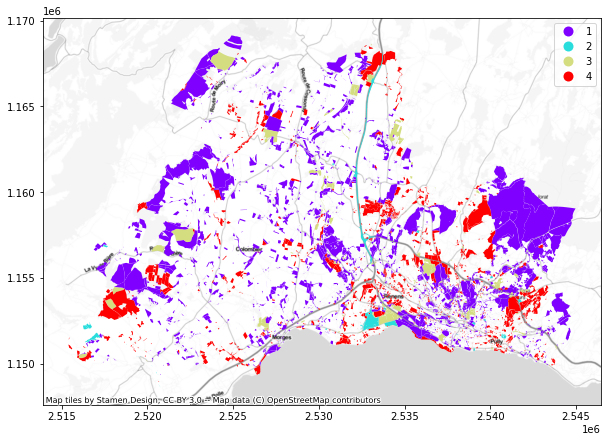

In [22]:
import contextily as cx
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
parcelles_pot_geom.plot(ax=ax, cmap='rainbow', column='code', legend=True)
cx.add_basemap(ax=ax, crs=2056, source=cx.providers.Stamen.TonerLite)

In [23]:
#parcelles_pot_geom['nom_commune' == 'Apples']
mex  = parcelles_pot_geom.loc[parcelles_pot_geom['nom_commune'] == 'Mex (VD)']
#mex  = parcelles_pot_geom.loc[parcelles_pot_geom['fiche_id'] == '138_36']

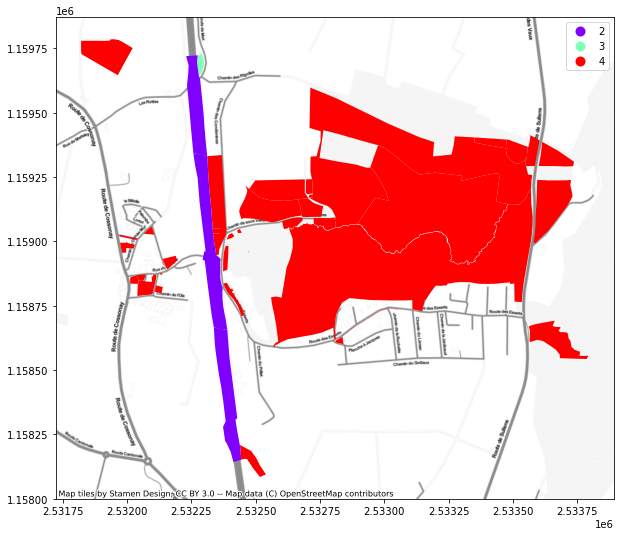

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
mex.plot(ax=ax, cmap='rainbow', column='code', legend=True)
cx.add_basemap(ax=ax, crs=2056, source=cx.providers.Stamen.TonerLite)

In [25]:
mex

,no_commune,no_com_can,IDEX2000,fiche_id,nom_commune,immeuble,code,geometry
875,5489,65,065000005,65_5,Mex (VD),5,4,"POLYGON ((2532061.341 1158846.223, 2532051.441..."
876,5489,65,065000007,65_7,Mex (VD),7,4,"POLYGON ((2532038.371 1159005.755, 2532013.881..."
877,5489,65,065000008,65_8,Mex (VD),8,4,"POLYGON ((2532040.587 1158787.629, 2532042.393..."
878,5489,65,065000012,65_12,Mex (VD),12,4,"POLYGON ((2532138.062 1158877.133, 2532136.182..."
879,5489,65,065000014,65_14,Mex (VD),14,4,"POLYGON ((2532108.006 1158804.667, 2532109.331..."
880,5489,65,065000017,65_17,Mex (VD),17,4,"POLYGON ((2532383.043 1158815.931, 2532381.913..."
881,5489,65,065000168,65_168,Mex (VD),168,4,"POLYGON ((2532814.360 1159419.149, 2532803.420..."
882,5489,65,065000181,65_181,Mex (VD),181,4,"POLYGON ((2532754.707 1159095.554, 2532751.267..."
883,5489,65,065000183,65_183,Mex (VD),183,4,"POLYGON ((2532805.818 1159089.984, 2532812.057..."
884,5489,65,065000185,65_185,Mex (VD),185,4,"POLYGON ((2532658.246 1159057.953, 2532656.296..."
